# Calculate sigmav vs. mDM for simulated DM datasets

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt

import numpy as np
import astropy.units as u

from gammapy.maps import MapAxis, RegionNDMap
from gammapy.modeling.models import PointSpatialModel
from gammapy.modeling.models import SkyModel, Models
from gammapy.astro.darkmatter.utils import SigmaVEstimator, DMDatasetOnOff
from gammapy.astro.darkmatter import DarkMatterAnnihilationSpectralModel
from gammapy.irf import load_cta_irfs

## Define parameters for simulated observation

In [2]:
# -
livetime = 100 * u.h # in hours
offset = 0.5 * u.deg
FOVLON=0 * u.deg
FOVLAT=0 * u.deg

# Energy from 0.01 to 100 TeV with 20 bins/decade
energy = np.logspace(-1.8, 1.5, 20) * u.TeV

# Energy true wider range and higher number of bins
energy_true = np.logspace(-2, 2, 100) * u.TeV

# DMAnnihilation Model
JFAC = 3.41e19 * u.Unit("GeV2 cm-5") # point source
mDM = 5000*u.Unit("GeV")
channel = "b"
redshift = 0

## Build IRFs with the defined parameters

In [3]:
# Load IRFs
filename = (
    "$GAMMAPY_DATA/cta-1dc/caldb/data/cta/1dc/bcf/South_z20_50h/irf_file.fits"
)
cta_irf = load_cta_irfs(filename)

NDDataArray summary info
MapAxis

	name       : energy_true
	unit       : 'TeV'     
	nbins      : 42        
	node type  : edges     
	edges min  : 1.3e-02 TeV
	edges max  : 2.0e+02 TeV
	interp     : log       
MapAxis

	name       : offset    
	unit       : 'deg'     
	nbins      : 6         
	node type  : edges     
	edges min  : 0.0e+00 deg
	edges max  : 6.0e+00 deg
	interp     : lin       
Data           : size =   252, min =  0.000 m2, max = 5371581.000 m2



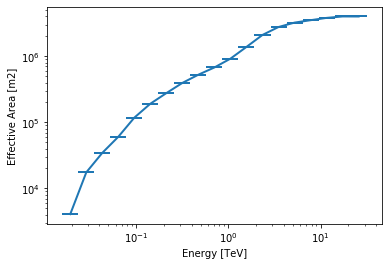

In [4]:
aeff = cta_irf["aeff"].to_effective_area_table(offset=offset, energy=energy)
aeff.plot()
plt.loglog()
print(cta_irf["aeff"].data)

In [5]:
#edisp = cta_irf["edisp"].to_energy_dispersion(
#    offset=offset, e_true=energy_true, e_reco=energy
#)
#edisp.plot_matrix()
#print(edisp.data)

## Build the background counts from PSF and IRF background

In [6]:
containment = 0.68
energies = np.sqrt(energy[1:] * energy[:-1])
psf = cta_irf["psf"].to_energy_dependent_table_psf(theta=offset)
on_radii = psf.containment_radius(energy=energies, fraction=containment)
solid_angles = 2 * np.pi * (1 - np.cos(on_radii)) * u.sr

#
aeff.data.data *= containment

In [7]:
bkg_data = cta_irf["bkg"].evaluate_integrate(
    fov_lon=FOVLON, fov_lat=FOVLAT, energy_reco=energy
)
axis = MapAxis.from_nodes(energies * u.TeV, interp="log", name="energy")
bkg = RegionNDMap.create(f"icrs;circle({FOVLON.value}, {FOVLAT.value}, {offset.value})", axes=[axis])
bkg.quantity = (bkg_data * solid_angles).to_value("h-1")*livetime.value

#bkg = CountsSpectrum(
#    energy[:-1],
#    energy[1:],
#    data=(bkg_data * solid_angles).to_value("h-1")*livetime
#)

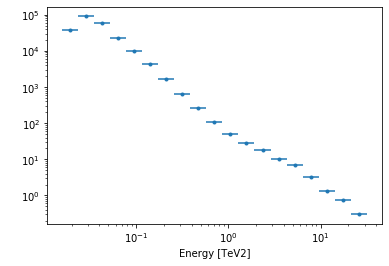

In [8]:
bkg.plot()

## Simulate OnOff observation with DM emission model

In [9]:
# DM Spatial Component
spatial_model = PointSpatialModel(
    lon_0="0 deg", lat_0="0 deg", frame="icrs"
)

In [10]:
# DM Flux
spectral_model = DarkMatterAnnihilationSpectralModel(
    mass=mDM, 
    channel=channel, 
    jfactor=JFAC, 
    z=redshift
)

In [11]:
from gammapy.modeling.models import Absorption, AbsorbedSpectralModel
#absorption_model = Absorption.read_builtin('dominguez')
#spectral_model = AbsorbedSpectralModel(spectral_model, absorption_model, redshift)

In [12]:
sky_model = SkyModel(spatial_model=spatial_model, spectral_model=spectral_model)
models = Models([sky_model])

In [13]:
dataset = DMDatasetOnOff(
    counts=bkg,
    aeff=aeff,
    models=models,
    livetime=livetime,
    acceptance=1,
    acceptance_off=5
)

In [14]:
nuisance = dict(
    j=JFAC,
    jobs=JFAC,
    sigmaj=0.1*JFAC,
    sigmatau=0.01,
    # width=5 # default value / optional param 
)
dataset.nuisance = nuisance

## The SigmaVEstimator

**Enable inspection**

In [15]:
import logging
logging.basicConfig()
#logging.getLogger("gammapy.astro.darkmatter.utils").setLevel("WARNING")
logging.getLogger("gammapy.astro.darkmatter.utils").setLevel("DEBUG")

**Instatiate estimator**

In [16]:
masses = [100, 200, 500, 1000, 5000, 10000, 50000]*u.GeV
channels = ["b", "tau", "Z"] 
estimator = SigmaVEstimator(dataset, masses, channels)

**Run estimator and fetch results**

In [17]:
%%time
# stat_profile_opts=dict(bounds=(-25, 100), nvalues=50)     # default param
# if nuisance = True the process takes the nuisance parameters into account
result = estimator.run(runs=3, nuisance=True)

/opt/miniconda3/envs/gammapy-dev/lib/python3.7/site-packages/astropy/units/quantity.py:481: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/opt/miniconda3/envs/gammapy-dev/lib/python3.7/site-packages/astropy/units/quantity.py:481: RuntimeWarning: invalid value encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
INFO:gammapy.astro.darkmatter.utils:----
INFO:gammapy.astro.darkmatter.utils:Run: 0
INFO:gammapy.astro.darkmatter.utils:Channel: b
INFO:gammapy.astro.darkmatter.utils:Mass: 100.0 GeV
/opt/miniconda3/envs/gammapy-dev/lib/python3.7/site-packages/astropy/units/quantity.py:481: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/opt/miniconda3/envs/gammapy-dev/lib/python3.7/site-packages/astropy/units/quantity.py:481: RuntimeWarning: invalid value encountered in true_divide
  r

INFO:gammapy.astro.darkmatter.utils:----
INFO:gammapy.astro.darkmatter.utils:Run: 0
INFO:gammapy.astro.darkmatter.utils:Channel: tau
INFO:gammapy.astro.darkmatter.utils:Mass: 10000.0 GeV
DEBUG:gammapy.astro.darkmatter.utils:ZeroDeltaL: 0.0144 	| LZero: 109.350 	| LMin:  109.335
DEBUG:gammapy.astro.darkmatter.utils:MaximumDeltaL: 341.4282 	| LMax: 450.778 	| LMin:  109.350
DEBUG:gammapy.astro.darkmatter.utils:SvBestFound: -0.544 	| SvBest: 0.000 	| SvUL: 7.384
DEBUG:gammapy.astro.darkmatter.utils:JBest: 3.39531398075622e+19 GeV2 / cm5
INFO:gammapy.astro.darkmatter.utils:Sigma v:2.215183928618568e-25 cm3 / s
INFO:gammapy.astro.darkmatter.utils:----
INFO:gammapy.astro.darkmatter.utils:Run: 0
INFO:gammapy.astro.darkmatter.utils:Channel: tau
INFO:gammapy.astro.darkmatter.utils:Mass: 50000.0 GeV
DEBUG:gammapy.astro.darkmatter.utils:ZeroDeltaL: 4.6776 	| LZero: 109.350 	| LMin:  104.672
DEBUG:gammapy.astro.darkmatter.utils:MaximumDeltaL: 7.1789 	| LMax: 111.851 	| LMin:  104.672
DEBUG:gammapy

DEBUG:gammapy.astro.darkmatter.utils:MaximumDeltaL: 214.4294 	| LMax: 326.023 	| LMin:  111.594
DEBUG:gammapy.astro.darkmatter.utils:SvBestFound: 18.194 	| SvBest: 18.194 	| SvUL: 31.895
DEBUG:gammapy.astro.darkmatter.utils:JBest: 4.1798595132355035e+19 GeV2 / cm5
INFO:gammapy.astro.darkmatter.utils:Sigma v:9.56862388367594e-25 cm3 / s
INFO:gammapy.astro.darkmatter.utils:----
INFO:gammapy.astro.darkmatter.utils:Run: 1
INFO:gammapy.astro.darkmatter.utils:Channel: b
INFO:gammapy.astro.darkmatter.utils:Mass: 10000.0 GeV
DEBUG:gammapy.astro.darkmatter.utils:ZeroDeltaL: 7.3085 	| LZero: 116.605 	| LMin:  109.297
DEBUG:gammapy.astro.darkmatter.utils:MaximumDeltaL: 118.2207 	| LMax: 227.517 	| LMin:  109.297
DEBUG:gammapy.astro.darkmatter.utils:SvBestFound: 26.649 	| SvBest: 26.649 	| SvUL: 43.643
DEBUG:gammapy.astro.darkmatter.utils:JBest: 4.0971909024698106e+19 GeV2 / cm5
INFO:gammapy.astro.darkmatter.utils:Sigma v:1.3092830309081411e-24 cm3 / s
INFO:gammapy.astro.darkmatter.utils:----
INFO

INFO:gammapy.astro.darkmatter.utils:Sigma v:4.512512715529841e-25 cm3 / s
INFO:gammapy.astro.darkmatter.utils:----
INFO:gammapy.astro.darkmatter.utils:Run: 1
INFO:gammapy.astro.darkmatter.utils:Channel: Z
INFO:gammapy.astro.darkmatter.utils:Mass: 5000.0 GeV
DEBUG:gammapy.astro.darkmatter.utils:ZeroDeltaL: 6.7277 	| LZero: 116.605 	| LMin:  109.877
DEBUG:gammapy.astro.darkmatter.utils:MaximumDeltaL: 44.1509 	| LMax: 154.028 	| LMin:  109.877
DEBUG:gammapy.astro.darkmatter.utils:SvBestFound: 39.716 	| SvBest: 39.716 	| SvUL: 65.938
DEBUG:gammapy.astro.darkmatter.utils:JBest: 2.1664267256319824e+19 GeV2 / cm5
INFO:gammapy.astro.darkmatter.utils:Sigma v:1.9781254016396352e-24 cm3 / s
INFO:gammapy.astro.darkmatter.utils:----
INFO:gammapy.astro.darkmatter.utils:Run: 1
INFO:gammapy.astro.darkmatter.utils:Channel: Z
INFO:gammapy.astro.darkmatter.utils:Mass: 10000.0 GeV
DEBUG:gammapy.astro.darkmatter.utils:ZeroDeltaL: 7.1353 	| LZero: 116.605 	| LMin:  109.470
DEBUG:gammapy.astro.darkmatter.uti

DEBUG:gammapy.astro.darkmatter.utils:ZeroDeltaL: 0.0100 	| LZero: 106.094 	| LMin:  106.084
DEBUG:gammapy.astro.darkmatter.utils:MaximumDeltaL: 930.3188 	| LMax: 1036.403 	| LMin:  106.084
DEBUG:gammapy.astro.darkmatter.utils:SvBestFound: 0.352 	| SvBest: 0.352 	| SvUL: 7.158
DEBUG:gammapy.astro.darkmatter.utils:JBest: 1.7688296389205914e+19 GeV2 / cm5
INFO:gammapy.astro.darkmatter.utils:Sigma v:2.1474398002981724e-25 cm3 / s
INFO:gammapy.astro.darkmatter.utils:----
INFO:gammapy.astro.darkmatter.utils:Run: 2
INFO:gammapy.astro.darkmatter.utils:Channel: tau
INFO:gammapy.astro.darkmatter.utils:Mass: 5000.0 GeV
DEBUG:gammapy.astro.darkmatter.utils:ZeroDeltaL: 0.4252 	| LZero: 106.094 	| LMin:  105.669
DEBUG:gammapy.astro.darkmatter.utils:MaximumDeltaL: 362.8694 	| LMax: 468.963 	| LMin:  106.094
DEBUG:gammapy.astro.darkmatter.utils:SvBestFound: -3.193 	| SvBest: 0.000 	| SvUL: 5.800
DEBUG:gammapy.astro.darkmatter.utils:JBest: 2.004636761760375e+19 GeV2 / cm5
INFO:gammapy.astro.darkmatter.

CPU times: user 5min 38s, sys: 2.5 s, total: 5min 41s
Wall time: 5min 42s


**Display results for channel b and run 1**

In [18]:
cols = ["mass", "sigma_v", "sv_ul", "sv_best", "j_best"]
result["runs"]["b"][2][cols]

mass,sigma_v,sv_ul,sv_best,j_best
GeV,cm3 / s,,,GeV2 / cm5
float64,float64,float64,float64,float64
100.0,2.1492770321495538e-24,71.64256773831846,21.17067234641946,3.2833682887389696e+19
200.0,1.0391736624556794e-24,34.63912208185598,14.777384409351905,5.001605429889549e+19
500.0,6.583957367474957e-25,21.946524558249855,8.470598958315577,4.945031112227334e+19
1000.0,9.256410052660012e-25,30.854700175533374,6.771570461839991,2.2715184473052537e+19
5000.0,4.501350735539443e-25,15.004502451798142,0.0,3.709302295310778e+19
10000.0,4.792464013512653e-25,15.974880045042175,0.0,3.34275201118228e+19
50000.0,5.846844051736353e-25,19.48948017245451,0.0,5.079174466872442e+19


**Plot likelihood profile for a specific fit**

In [19]:
idx = np.argwhere(masses.value==100)
profile = result["runs"]["Z"][0]["statprofile"][idx][0][0]

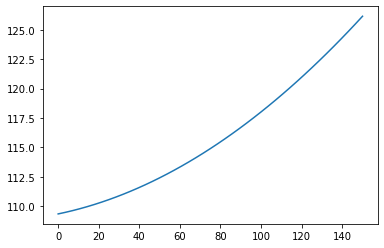

In [20]:
plt.plot(profile["values"], profile["stat"]);

## Obtained results

In [21]:
result["mean"]["b"]

mass,sigma_v,sigma_v_std,jfactor,jfactor_std
GeV,cm3 / s,cm3 / s,GeV2 / cm5,GeV2 / cm5
float64,float64,float64,float64,float64
100.0,1.3410813308982864e-24,5.720832856460314e-25,3.5282120157016162e+19,2.4702163137806577e+18
200.0,7.860509093396016e-25,1.7908147799753387e-25,4.077104666670251e+19,6.757225664322541e+18
500.0,5.098135871108717e-25,1.2311187520730543e-25,4.860766925067376e+19,2.2507577581507812e+18
1000.0,6.129877946907663e-25,2.2356697985373585e-25,3.809964346281987e+19,1.1074266104002486e+19
5000.0,8.037631888355753e-25,2.508014187005983e-25,3.5630374506126954e+19,5.727607091556271e+18
10000.0,1.0602176713648484e-24,4.121984567780985e-25,3.2200954127726727e+19,7.711129136631625e+18
50000.0,1.3199141089698871e-24,7.040605897625228e-25,4.70256971586155e+19,2.694189669267697e+18


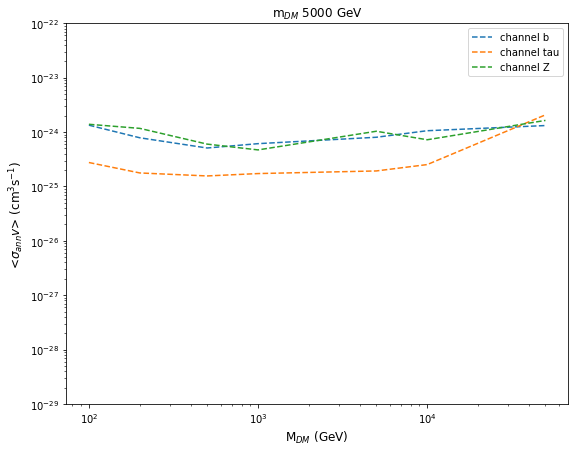

In [22]:
plt.figure(figsize=(9,7))
plt.ylim(1e-29, 1e-22)
plt.ylabel(r"<$\sigma_{ann}v$> (cm$^3$s$^{-1}$)", fontsize=12)
plt.xlabel("M$_{DM}$ (GeV)", fontsize=12)
plt.title('m$_{DM}$ 5000 GeV')

for ch in channels:
    plt.loglog(
        result["mean"][ch]["mass"].data,
        result["mean"][ch]["sigma_v"].data,
        ls="--",
        label='channel {}'.format(ch)
       )
plt.legend();